In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from data.data import data_loader
from code.models import TimeSeriesTransformer

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [3]:
torch.cuda.is_available()

True

#### 加载数据集
`assemble`是容器对象  
`self.features`  
`self.labels`

In [4]:
assemble = data_loader("data/collection_of_peptide_data.csv", max_length = 10)
assemble.get_dataset(batch_size = 2000)

Info: data loading completely, 62159 contained
Train: <class 'torch.Tensor'> torch.Size([43511, 10])
Valid: <class 'torch.Tensor'> torch.Size([18648, 10])


In [5]:
def Transformer_training(assemble, num_epochs):
    # 创建模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeSeriesTransformer(input_size=21, output_size=1).to(device)
    loop = tqdm(total=num_epochs)
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_history = []
    val_history = []
    # 提取数据加载
    train_loader = assemble.t_loader
    val_loader = assemble.v_loader
    # 训练模型
    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            # 移动至gpu
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            # 训练梯度
            optimizer.zero_grad()
            mask = torch.tril(torch.ones(1, 1)).to(device) == 0  # 创建遮罩并移动到GPU
            outputs = model(batch_x, mask)
            loss = criterion(outputs, batch_y)
            train_loss += loss.item() * batch_x.size(0)
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        train_history.append(train_loss)
        
        model.eval()  # 设置模型为评估模式
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                # 移动至gpu
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x, mask)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_x.size(0)
        val_loss /= len(val_loader.dataset)
        val_history.append(val_loss)
        
        loop.set_postfix(train_loss=train_loss, val_loss=val_loss)
        loop.update(1)
    loop.close()
    history = {}
    history["train"] = train_history
    history["val"] = val_history
    return model, history

In [6]:
num_epochs = 200
model, history = \
Transformer_training(assemble,
                     num_epochs = num_epochs)

  0%|          | 0/200 [00:00<?, ?it/s]

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"", count_parameters(model))

 58209


Text(0.5, 1.0, 'loss: 0.00424')

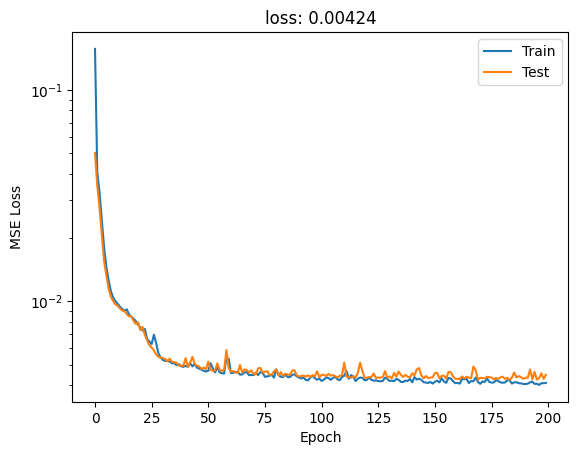

In [8]:
plt.plot(np.arange(num_epochs), history["train"], label="Train")
plt.plot(np.arange(num_epochs), history["val"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.yscale("log")
plt.title(f"loss: {np.min(history['val']):.5f}")

In [9]:
# 保存模型
save_model_path = "model/transformer1008A424.pth"
torch.save(model.state_dict(), save_model_path)
# 加载模型
model = TimeSeriesTransformer(input_size=21, output_size=1)
model.load_state_dict(torch.load(save_model_path))
model.eval()  # 设置模型为评估模式

TimeSeriesTransformer(
  (embedding): Embedding(21, 32)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (attention): SelfAttention(
        (values): Linear(in_features=4, out_features=4, bias=False)
        (keys): Linear(in_features=4, out_features=4, bias=False)
        (queries): Linear(in_features=4, out_features=4, bias=False)
        (fc_out): Linear(in_features=32, out_features=32, bias=True)
      )
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc_out): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
predictions = []
ground_truth = []
model.eval()  # 设置模型为评估模式

with torch.no_grad():
    for batch_x, batch_y in assemble.v_loader:
        batch_x = batch_x.to(device)  # 将输入张量移动到GPU（如果可用）
        mask = torch.tril(torch.ones(1, 1)).to(device) == 0  # 创建遮罩并移动到GPU
        outputs = model(batch_x, mask)
        predictions.append(outputs.cpu().detach().numpy())
        ground_truth.append(batch_y.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis=0)  # 将预测结果连接起来
ground_truth = np.concatenate(ground_truth, axis=0)

Text(0, 0.5, 'Prediction')

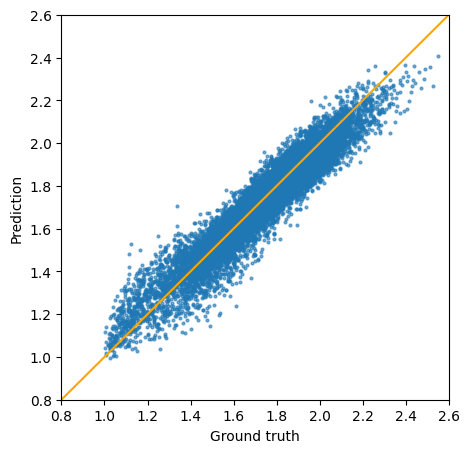

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(ground_truth, predictions, s=4, alpha=0.6)
plt.plot([0.8, 2.6], [0.8, 2.6], color="orange")
plt.ylim((0.8, 2.6))
plt.xlim((0.8, 2.6))
plt.xlabel("Ground truth")
plt.ylabel("Prediction")

In [12]:
def save_history_to_txt(history, file_path):
    with open(file_path, 'w') as f:
        train_history = history['train']
        val_history = history['val']
        for train_loss, val_loss in zip(train_history, val_history):
            f.write(f"{train_loss} {val_loss}\n")

In [13]:
save_history_to_txt(history, 'history—transformer1008A424.pth.txt')

In [14]:
with open("r2.txt", 'w') as f:
    for truth, predict in zip(ground_truth, predictions):
        f.write(f"{truth} {predict}\n")